<a href="https://colab.research.google.com/github/yandexdataschool/MLatImperial2022/blob/master/Seminars/lab_08_01_Rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/MLatImperial2022/main/Data/names

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [ ]:
!head names

In [ ]:
import os

with open("names") as f:
    names = f.read()[:-1].split('\n')

In [ ]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

In [ ]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=range(MAX_LENGTH + 1));

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [ ]:
# all unique characters go here
tokens = list(set(''.join(name for name in names)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"
print(''.join(sorted(tokens)))

### Convert characters to integers

Torch is built for crunching numbers, not strings. 
To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class CharTokenizer():
    def __init__(self):
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2
        
        self.token2id = {"<PAD>": self.pad_id, "<BOS>": self.bos_id, "<EOS>" : self.eos_id}
        self.id2token = {self.pad_id: "<PAD>", self.bos_id: "<BOS>", self.eos_id: "<EOS>"}
        
    def fit(self, vocab):
        id = 3
        for elem in vocab:
            self.token2id[elem] = id
            self.id2token[id] = elem
            id += 1
            
    def tokenize(self, seq):
        return list(seq)
    
    @property
    def vocab_size(self):
        return len(self.token2id)
    
    def encode(self, token_seq):
        return [self.bos_id] + [self.token2id[elem] for elem in token_seq] + [self.eos_id]
    
    def decode(self, id_seq):
        dec_seq = []
        for elem in id_seq:
            if (elem == self.bos_id):
                continue
            if ((elem == self.eos_id) or (elem == self.pad_id)):
                return dec_seq
            dec_seq.append(self.id2token[elem])
        return dec_seq
    
class NameDataset(Dataset):
    def __init__(self, data, tokenizer):
        super().__init__()
        
        self.tokenizer = tokenizer
        self.data = []
        
        for seq in data:
            token_seq = tokenizer.tokenize(seq)
            encoded_seq = tokenizer.encode(token_seq)
            self.data.append(encoded_seq)
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]).cuda()
    
class PaddingCollator():
    def __init__(self, pad_id, device, batch_first=True):
        self.pad_id = pad_id
        self.device = device
        self.batch_first = batch_first
        
    def __call__(self, batch):
        out = pad_sequence(batch, padding_value=self.pad_id, batch_first=self.batch_first).to(self.device)
        return out

In [ ]:
tokenizer = CharTokenizer()
tokenizer.fit(tokens)
pad_id = tokenizer.pad_id

In [ ]:
BATCH_SIZE = 64

name_ds = NameDataset(names, tokenizer)
collator = PaddingCollator(tokenizer.pad_id, 'cuda')
name_dl = DataLoader(name_ds, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)

In [ ]:
next(iter(name_dl))

# Recurrent neural network

We can unroll recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.

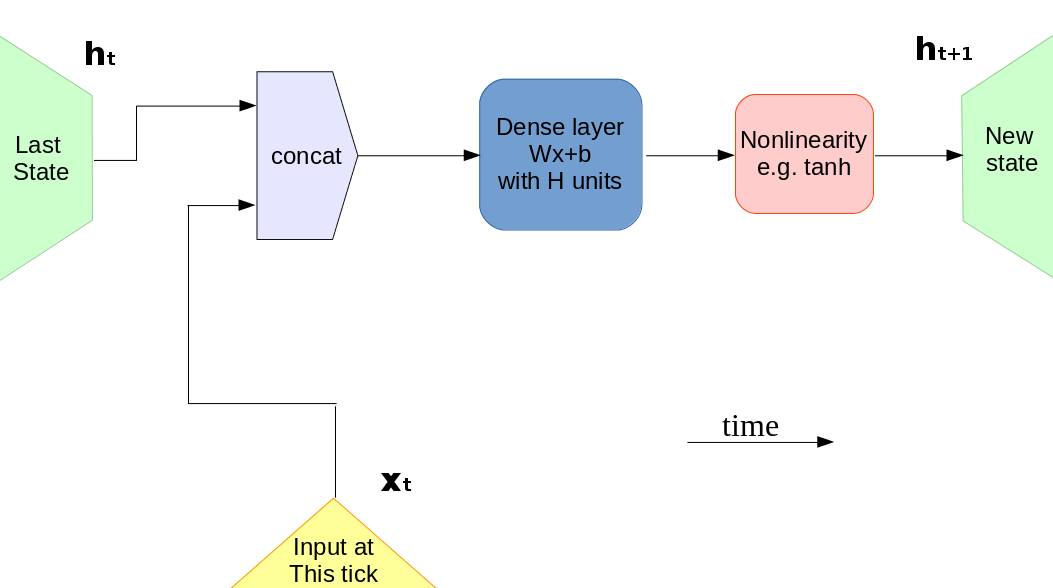

Since we're training a language model, there should also be:
* An embedding layer that assigns each token id to an embedding vector.
* An output layer that predicts probabilities of next token

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, vocab_size, embedding_dim, rnn_hidden_dim, softmax_T = 1.0):
        super().__init__()
        self.hidden_size = rnn_hidden_dim
        self.softmax_T = softmax_T
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_id, max_norm=1.0)
        self.rnn_update = nn.Linear(rnn_hidden_dim + embedding_dim, rnn_hidden_dim)
        self.rnn_to_logits = nn.Linear(rnn_hidden_dim, vocab_size)
        
    def forward(self, x_t, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get next hidden state
        h_next = <YOUR_CODE>
        
        assert h_next.size() == h_prev.size()
        
        # compute logits for next character probs
        logits = <YOUR_CODE>
        
        return h_next, F.log_softmax(logits/self.softmax_T, -1)
    
    def init_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.hidden_size).cuda()

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=16, rnn_hidden_dim=64):
        super().__init__()
        self.RNNCell = CharRNNCell(vocab_size, embedding_dim, rnn_hidden_dim)

    def forward(self, X):
        h_t = self.RNNCell.init_state(X.shape[0])
        <YOUR_CODE>
        return h_t, logprobs

In [ ]:
batch = next(iter(name_dl))
rnn = CharRNN(tokenizer.vocab_size).cuda()

_, logp_seq = rnn(batch)

assert isinstance(logp_seq, torch.Tensor) and torch.max(logp_seq).item() <= 0
assert tuple(logp_seq.size()) ==  batch.shape + (tokenizer.vocab_size,)

### Likelihood and gradients

We can now train our neural network to minimize crossentropy (maximize negative-log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` - a matrix of token ids shifted i step to the left so i-th element is acutally the "next token" for i-th prediction

In [ ]:
predictions = logp_seq[:, :-1]
target = batch[:, 1:]

criterion = torch.nn.NLLLoss(ignore_index = tokenizer.pad_id)

loss = criterion(predictions.transpose(1, 2), target)
loss.backward()

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [ ]:
def train(model, optimizer, criterion, name_dl, n_epochs=10):
    history = []
    model.train()
    for n_epochs in range(n_epochs):
        for batch in name_dl:
            optimizer.zero_grad()
            _, logp_seq = model(batch)
            
            # compute loss
            predictions = logp_seq[:, :-1]
            target = batch[:, 1:]
            
            loss = criterion(predictions.transpose(1, 2), target)
            loss.backward()
            optimizer.step()

            history.append(loss.item())
            
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
from IPython.display import clear_output

tokenizer = CharTokenizer()
tokenizer.fit(tokens)

BATCH_SIZE = 64

name_ds = NameDataset(names, tokenizer)
collator = PaddingCollator(tokenizer.pad_id, 'cuda')
name_dl = DataLoader(name_ds, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)

rnn = CharRNN(tokenizer.vocab_size, embedding_dim=16, rnn_hidden_dim=64).cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=7e-4)
criterion = torch.nn.NLLLoss(ignore_index = tokenizer.pad_id)
train(rnn, optimizer, criterion, name_dl, n_epochs=15)

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. 
All we need is the single rnn step function you have defined in `char_rnn.forward`.

In [ ]:
def generate_sample(model, tokenizer, seed_phrase='', max_length=15, T=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param T: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    model.eval()
    batch = torch.tensor(tokenizer.encode(tokenizer.tokenize(seed_phrase)))[:-1].unsqueeze(0).cuda()
    h_t, logp_seq = model(batch)
    logp_seq = logp_seq[:, -1, :]
    model.RNNCell.softmax_T = T
    
    # start generating
    for t in range(max_length - len(seed_phrase)):
        next_x_t = torch.multinomial(torch.exp(logp_seq[0, :]), 1).cuda()
        if (next_x_t.item() == tokenizer.eos_id):
            break
        h_t, logp_seq = model.RNNCell(next_x_t, h_t)
        batch = torch.cat((batch, next_x_t.unsqueeze(1)), dim=1)
        
    return ''.join(tokenizer.decode(batch[0].tolist()))

In [ ]:
for _ in range(10):
    print(generate_sample(rnn, tokenizer, T=2))

In [ ]:
for _ in range(30):
    print(generate_sample(rnn, tokenizer, seed_phrase='Alex', T=1))

### Try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names


What we just did is a manual low-level implementation of RNN. While it's cool, i guess you won't like the idea of re-writing it from scratch on every occasion. 

As you might have guessed, torch has a solution for this. To be more specific, there are two options:
* `nn.RNNCell(emb_size, rnn_num_units)` - implements a single step of RNN just like you did. Basically concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - implements the whole rnn_loop for you.

There's also `nn.LSTMCell` vs `nn.LSTM`, `nn.GRUCell` vs `nn.GRU`, etc. etc.

In this example we'll rewrite the char_rnn and rnn_loop using high-level rnn API.

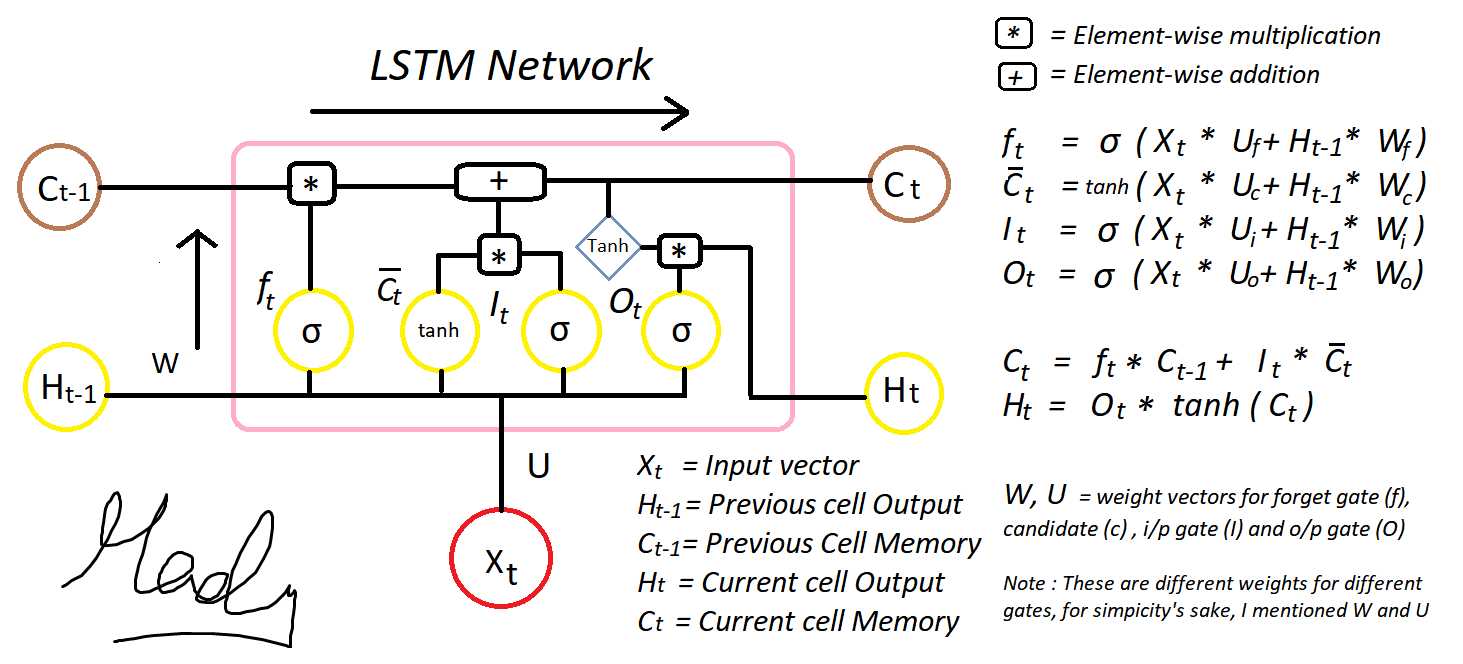

[Source](https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235)

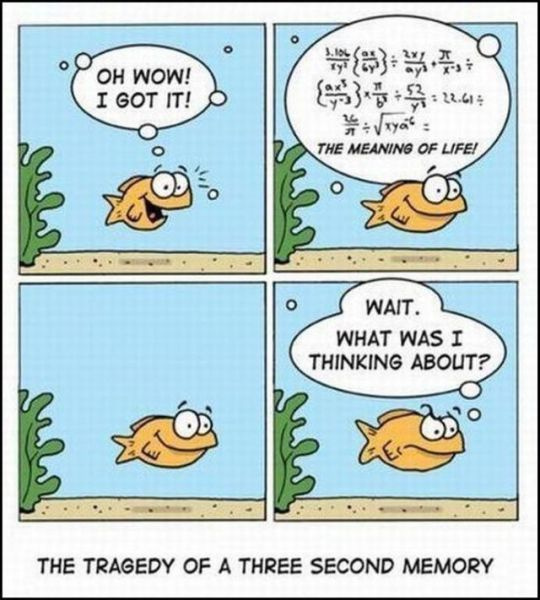

In [ ]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_hidden_dim, softmax_T = 1.0):
        super().__init__()
        self.hidden_size = rnn_hidden_dim
        self.softmax_T = softmax_T
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_id, max_norm=1.0)
        self.lstm = nn.LSTM(embedding_dim, rnn_hidden_dim, batch_first=True)
        self.rnn_to_logits = nn.Linear(rnn_hidden_dim, vocab_size)
        
    def forward(self, x, h_c=None):
        x_emb = self.embedding(x)
        x_out, (h_last, c_last) = self.lstm(x_emb, h_c)
        logits = self.rnn_to_logits(x_out)
        
        return (h_last, c_last), F.log_softmax(logits/self.softmax_T, -1)

In [ ]:
def generate_sample(model, tokenizer, seed_phrase='', max_length=15, T=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param T: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    model.eval()
    batch = torch.tensor(tokenizer.encode(tokenizer.tokenize(seed_phrase)))[:-1].unsqueeze(0).cuda()
    (h_t, c_t), logp_seq = model(batch)
    model.softmax_T = T
    
    # start generating
    for t in range(max_length - len(seed_phrase)):
        next_x_t = torch.multinomial(torch.exp(logp_seq[:, -1, :]), 1).cuda()
        if (next_x_t.item() == tokenizer.eos_id):
            break
        (h_t, c_t), logp_seq = model(next_x_t, (h_t, c_t))
        batch = torch.cat((batch, next_x_t), dim=1)
        
    return ''.join(tokenizer.decode(batch[0].tolist()))

In [ ]:
rnn = CharLSTM(tokenizer.vocab_size, embedding_dim=tokenizer.vocab_size, rnn_hidden_dim=256).cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=7e-4)
criterion = torch.nn.NLLLoss(ignore_index = tokenizer.pad_id)
train(rnn, optimizer, criterion, name_dl, n_epochs=15)

In [ ]:
for _ in range(30):
    print(generate_sample(rnn, tokenizer, seed_phrase='Alex', T=1))

### N-gram Model

In [ ]:
class NGramTokenizer():
    def __init__(self, N):
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2
        self.N = N
        
        self.token2id = {"<PAD>": self.pad_id, "<BOS>": self.bos_id, "<EOS>" : self.eos_id}
        self.id2token = {self.pad_id: "<PAD>", self.bos_id: "<BOS>", self.eos_id: "<EOS>"}
       
    def extract_vocab(self, data):
        """
        Get a set of all possible N-grams in data
        """
        vocab = set()
        <YOUR_CODE>
        return list(vocab)
    
    def fit(self, vocab):
        id = 3
        for elem in vocab:
            self.token2id[elem] = id
            self.id2token[id] = elem
            id += 1
            
    def tokenize(self, seq):
        """
        Represent a string sequence as a list of N-grams
        """
        tokens = []
        <YOUR_CODE>
        return tokens
    
    @property
    def vocab_size(self):
        return len(self.token2id)
    
    def encode(self, token_seq):
        return [self.bos_id] + [self.token2id[elem] for elem in token_seq] + [self.eos_id]
    
    def decode(self, id_seq):
        """
        Decode a series of ids into a list of characters
        """
        dec_seq = []
        <YOUR_CODE>
        return dec_seq

In [ ]:
tokenizer = NGramTokenizer(2)
vocab = tokenizer.extract_vocab(names)
print(f"vocab_size is {len(vocab)} elements")
tokenizer.fit(vocab)

In [ ]:
tokenizer.tokenize("Alexander")

In [ ]:
BATCH_SIZE = 64

name_ds = NameDataset(names, tokenizer)
collator = PaddingCollator(tokenizer.pad_id, 'cuda')
name_dl = DataLoader(name_ds, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)

In [ ]:
rnn = CharLSTM(tokenizer.vocab_size, embedding_dim=256, rnn_hidden_dim=300).cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=3e-3)
criterion = torch.nn.NLLLoss(ignore_index = tokenizer.pad_id)
train(rnn, optimizer, criterion, name_dl, n_epochs=25)

In [ ]:
for _ in range(30):
    print(generate_sample(rnn, tokenizer, seed_phrase='Alex', T=1))